# Detection of AI-Generated Synthetic Images with a Lightweight CNN
## This notebook implements the lightweight CNN architecture from the paper:
## "Detection of AI-Generated Synthetic Images with a Lightweight CNN" (AI, MDPI, 2024)


## Imports + Seed

In [1]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# For Grad-CAM cell later
import warnings
warnings.filterwarnings("ignore")


def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Config

In [2]:
@dataclass
class CFG:
    batch_size: int = 128
    num_workers: int = 0
    lr: float = 1e-3
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    data_root: str = "data"   # will be overridden per dataset
    img_size: int = 64        # will be overridden per dataset
    
cfg = CFG()
cfg

CFG(batch_size=128, num_workers=0, lr=0.001, device='cuda', data_root='data', img_size=64)

## Model Definition

In [3]:
class ConvBlock(nn.Module):
    """
    Conv block as described in the paper:
    Conv2D -> BatchNorm -> ReLU -> Conv2D -> ReLU -> MaxPool2d -> Dropout(p=0.3)
    """
    def __init__(self, in_channels: int, out_channels: int, dropout_p: float = 0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, x):
        return self.block(x)


class LightweightCNN(nn.Module):
    """
    Lightweight CNN from the paper:
    4 ConvBlocks (64, 128, 256, 512) -> AdaptiveAvgPool -> 
    FC(512) -> FC(512) -> FC(1) + Sigmoid
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x.view(-1)

# sanity check
test_model = LightweightCNN().to(device)
print(test_model.__class__.__name__, "initialized.")

LightweightCNN initialized.


## Dataset Utilities

In [4]:
def build_full_dataset(root: str, img_size: int):
    """
    Builds a single dataset for a given root.
    - If root has subfolders like train/val/test each with class subdirs, we load all and concat.
    - Otherwise we assume root itself has class subfolders (fake/real or FAKE/REAL).
    Returns:
        full_dataset (ConcatDataset or ImageFolder), class_names (list[str])
    """
    base_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])

    root_path = Path(root)
    split_dirs = []
    for sub in ["train", "val", "test", "Train", "Val", "Test"]:
        d = root_path / sub
        if d.is_dir():
            split_dirs.append(d)

    if len(split_dirs) == 0:
        # assume root has class subdirs
        ds = datasets.ImageFolder(root=str(root_path), transform=base_transform)
        full_dataset = ds
        class_names = ds.classes
    else:
        parts = []
        classes = None
        for d in split_dirs:
            ds = datasets.ImageFolder(root=str(d), transform=base_transform)
            if classes is None:
                classes = ds.classes
            else:
                if ds.classes != classes:
                    raise ValueError(f"Inconsistent classes between splits under {root}")
            parts.append(ds)
        full_dataset = ConcatDataset(parts)
        class_names = classes

    return full_dataset, class_names


def get_dataloaders_70_15_15(root: str,
                              img_size: int,
                              batch_size: int,
                              num_workers: int,
                              run_seed: int,
                              device: str) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:
    """
    - Builds a full dataset from all subfolders.
    - Randomly splits into 70% train, 15% val, 15% test using run_seed.
    - Returns 3 dataloaders + class names.
    """
    full_dataset, class_names = build_full_dataset(root, img_size)

    n_total = len(full_dataset)
    n_train = int(0.70 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    if n_train == 0 or n_val == 0 or n_test == 0:
        raise ValueError(f"Too few samples in {root} for 70/15/15 split. Total={n_total}")

    generator = torch.Generator().manual_seed(run_seed)
    train_ds, val_ds, test_ds = random_split(
        full_dataset, [n_train, n_val, n_test], generator=generator
    )

    pin_mem = (device == "cuda")

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_mem
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_mem
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_mem
    )

    return train_loader, val_loader, test_loader, class_names

# quick dataset check (will fail if folders missing)
DATA_ROOT = Path.cwd() / "data"
for ds_name in ["CIFAKE", "MidJourney", "StyleGAN"]:
    print(ds_name, "->", (DATA_ROOT / ds_name).resolve())

CIFAKE -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\CIFAKE
MidJourney -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\MidJourney
StyleGAN -> E:\University\9th Semester\Deep Learning\PROJECT_Final\data\StyleGAN


## Training & Evaluation Helpers

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = (outputs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "loss": running_loss / total,
            "acc": correct / total
        })

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    all_labels = []
    all_probs = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.float().to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = (outputs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(outputs.cpu().numpy())

        pbar.set_postfix({
            "loss": running_loss / total,
            "acc": correct / total
        })

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    return running_loss / total, correct / total, all_labels, all_probs

## Experimental Loop

In [6]:
N_RUNS = 2

DATASETS = [
    {
        "name": "CIFAKE",
        "root": str((DATA_ROOT / "CIFAKE").resolve()),
        "img_size": 32,
        "num_epochs": 15,
    },
    {
        "name": "MidJourney",
        "root": str((DATA_ROOT / "MidJourney").resolve()),
        "img_size": 64,
        "num_epochs": 10,
    },
    {
        "name": "StyleGAN",
        "root": str((DATA_ROOT / "StyleGAN").resolve()),
        "img_size": 128,
        "num_epochs": 10,
    },
]

all_results = {}

for ds in DATASETS:
    ds_name = ds["name"]
    root = ds["root"]
    img_size = ds["img_size"]
    num_epochs = ds["num_epochs"]

    print("\n" + "=" * 80)
    print(f"DATASET: {ds_name}")
    print(f"ROOT   : {root}")
    print(f"IMG_SZ : {img_size} | EPOCHS: {num_epochs}")
    print("=" * 80)

    run_metrics = []

    for run_idx in range(N_RUNS):
        print(f"\n---- {ds_name} | Run {run_idx + 1}/{N_RUNS} ----")

        # Different seed per run (and dataset), but still deterministic overall
        run_seed = 42 + run_idx
        set_global_seed(run_seed)

        train_loader, val_loader, test_loader, class_names = get_dataloaders_70_15_15(
            root=root,
            img_size=img_size,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            run_seed=run_seed,
            device=cfg.device,
        )

        model = LightweightCNN().to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

        # store history for plotting later
        run_history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
            print(f"Train  -> loss: {tr_loss:.4f}, acc: {tr_acc:.4f}")
            print(f"Val    -> loss: {val_loss:.4f}, acc: {val_acc:.4f}")

            run_history["train_loss"].append(tr_loss)
            run_history["train_acc"].append(tr_acc)
            run_history["val_loss"].append(val_loss)
            run_history["val_acc"].append(val_acc)

        print("\nEvaluating on TEST set ...")
        test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)
        y_pred = (y_prob >= 0.5).astype(int)

        # classification_report with weighted averages
        cr = classification_report(
            y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
        )
        precision = cr["weighted avg"]["precision"]
        recall = cr["weighted avg"]["recall"]
        f1 = cr["weighted avg"]["f1-score"]

        cm = confusion_matrix(y_true, y_pred)

        print(f"\nRun {run_idx + 1} TEST metrics:")
        print(f"  loss     : {test_loss:.4f}")
        print(f"  accuracy : {test_acc:.4f}")
        print(f"  precision: {precision:.4f}")
        print(f"  recall   : {recall:.4f}")
        print(f"  f1-score : {f1:.4f}")

        run_metrics.append({
            "test_loss": test_loss,
            "test_acc": test_acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "history": run_history,
            "cm": cm,
        })

    # Aggregate over runs
    accs = np.array([m["test_acc"] for m in run_metrics])
    precs = np.array([m["precision"] for m in run_metrics])
    recs = np.array([m["recall"] for m in run_metrics])
    f1s = np.array([m["f1"] for m in run_metrics])

    results = {
        "acc_mean": accs.mean(), "acc_std": accs.std(),
        "prec_mean": precs.mean(), "prec_std": precs.std(),
        "rec_mean": recs.mean(), "rec_std": recs.std(),
        "f1_mean": f1s.mean(), "f1_std": f1s.std(),
        "per_run": run_metrics,
        "class_names": class_names,
        "num_epochs": num_epochs,
    }
    all_results[ds_name] = results

    print("\n" + "-" * 80)
    print(f"[{ds_name}] Summary over {N_RUNS} runs:")
    print(f"Accuracy : {results['acc_mean']*100:.2f} ± {results['acc_std']*100:.2f} %")
    print(f"Precision: {results['prec_mean']*100:.2f} ± {results['prec_std']*100:.2f} %")
    print(f"Recall   : {results['rec_mean']*100:.2f} ± {results['rec_std']*100:.2f} %")
    print(f"F1-score : {results['f1_mean']*100:.2f} ± {results['f1_std']*100:.2f} %")
    print("-" * 80)


DATASET: CIFAKE
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\CIFAKE
IMG_SZ : 32 | EPOCHS: 15

---- CIFAKE | Run 1/2 ----

Epoch 1/15

Epoch 1/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.2223, acc: 0.9132
Val    -> loss: 0.1567, acc: 0.9391

Epoch 2/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1553, acc: 0.9426
Val    -> loss: 0.1224, acc: 0.9533

Epoch 3/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1323, acc: 0.9512
Val    -> loss: 0.1132, acc: 0.9576

Epoch 4/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1193, acc: 0.9555
Val    -> loss: 0.1213, acc: 0.9566

Epoch 5/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1092, acc: 0.9597
Val    -> loss: 0.0869, acc: 0.9676

Epoch 6/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1005, acc: 0.9635
Val    -> loss: 0.0846, acc: 0.9677

Epoch 7/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0914, acc: 0.9661
Val    -> loss: 0.0920, acc: 0.9662

Epoch 8/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0864, acc: 0.9691
Val    -> loss: 0.0751, acc: 0.9707

Epoch 9/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0786, acc: 0.9714
Val    -> loss: 0.0735, acc: 0.9722

Epoch 10/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0733, acc: 0.9732
Val    -> loss: 0.0722, acc: 0.9722

Epoch 11/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0678, acc: 0.9750
Val    -> loss: 0.0701, acc: 0.9758

Epoch 12/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0640, acc: 0.9766
Val    -> loss: 0.0557, acc: 0.9793

Epoch 13/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0613, acc: 0.9778
Val    -> loss: 0.0568, acc: 0.9790

Epoch 14/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0567, acc: 0.9798
Val    -> loss: 0.0557, acc: 0.9796

Epoch 15/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0533, acc: 0.9809
Val    -> loss: 0.0510, acc: 0.9847

Evaluating on TEST set ...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]


Run 1 TEST metrics:
  loss     : 0.0476
  accuracy : 0.9842
  precision: 0.9842
  recall   : 0.9842
  f1-score : 0.9842

---- CIFAKE | Run 2/2 ----

Epoch 1/15

Epoch 1/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.2253, acc: 0.9124
Val    -> loss: 0.1474, acc: 0.9436

Epoch 2/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1592, acc: 0.9413
Val    -> loss: 0.1469, acc: 0.9469

Epoch 3/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1377, acc: 0.9492
Val    -> loss: 0.1392, acc: 0.9462

Epoch 4/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1233, acc: 0.9550
Val    -> loss: 0.1103, acc: 0.9629

Epoch 5/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1112, acc: 0.9588
Val    -> loss: 0.0962, acc: 0.9633

Epoch 6/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.1006, acc: 0.9636
Val    -> loss: 0.0954, acc: 0.9651

Epoch 7/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0933, acc: 0.9660
Val    -> loss: 0.0810, acc: 0.9695

Epoch 8/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0874, acc: 0.9679
Val    -> loss: 0.0914, acc: 0.9656

Epoch 9/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0813, acc: 0.9706
Val    -> loss: 0.1481, acc: 0.9456

Epoch 10/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0769, acc: 0.9721
Val    -> loss: 0.0746, acc: 0.9713

Epoch 11/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0699, acc: 0.9748
Val    -> loss: 0.0593, acc: 0.9781

Epoch 12/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0643, acc: 0.9766
Val    -> loss: 0.0681, acc: 0.9792

Epoch 13/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0601, acc: 0.9782
Val    -> loss: 0.0741, acc: 0.9756

Epoch 14/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0578, acc: 0.9785
Val    -> loss: 0.0667, acc: 0.9774

Epoch 15/15


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Train  -> loss: 0.0544, acc: 0.9801
Val    -> loss: 0.0523, acc: 0.9815

Evaluating on TEST set ...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]


Run 2 TEST metrics:
  loss     : 0.0509
  accuracy : 0.9823
  precision: 0.9823
  recall   : 0.9823
  f1-score : 0.9823

--------------------------------------------------------------------------------
[CIFAKE] Summary over 2 runs:
Accuracy : 98.32 ± 0.09 %
Precision: 98.33 ± 0.09 %
Recall   : 98.32 ± 0.09 %
F1-score : 98.32 ± 0.09 %
--------------------------------------------------------------------------------

DATASET: MidJourney
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\MidJourney
IMG_SZ : 64 | EPOCHS: 10

---- MidJourney | Run 1/2 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0305, acc: 0.9910
Val    -> loss: 0.0263, acc: 0.9967

Epoch 2/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0070, acc: 0.9993
Val    -> loss: 0.0021, acc: 0.9997

Epoch 3/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0104, acc: 0.9986
Val    -> loss: 0.0057, acc: 0.9989

Epoch 4/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0015, acc: 0.9997
Val    -> loss: 0.0000, acc: 1.0000

Epoch 5/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0011, acc: 0.9998
Val    -> loss: 0.0007, acc: 0.9998

Epoch 6/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0006, acc: 0.9999
Val    -> loss: 0.0000, acc: 1.0000

Epoch 7/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0003, acc: 0.9999
Val    -> loss: 0.0096, acc: 0.9995

Epoch 8/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0504, acc: 0.9975
Val    -> loss: 0.0178, acc: 0.9982

Epoch 9/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0058, acc: 0.9996
Val    -> loss: 0.0001, acc: 1.0000

Epoch 10/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0020, acc: 0.9999
Val    -> loss: 0.0005, acc: 0.9999

Evaluating on TEST set ...


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Run 1 TEST metrics:
  loss     : 0.0001
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000

---- MidJourney | Run 2/2 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0349, acc: 0.9887
Val    -> loss: 0.0156, acc: 0.9979

Epoch 2/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0049, acc: 0.9990
Val    -> loss: 0.0024, acc: 0.9995

Epoch 3/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0001, acc: 1.0000
Val    -> loss: 0.0000, acc: 1.0000

Epoch 4/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0059, acc: 0.9992
Val    -> loss: 0.0200, acc: 0.9998

Epoch 5/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0156, acc: 0.9986
Val    -> loss: 0.0021, acc: 0.9998

Epoch 6/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0021, acc: 0.9998
Val    -> loss: 0.0002, acc: 0.9999

Epoch 7/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0000, acc: 1.0000
Val    -> loss: 0.0000, acc: 1.0000

Epoch 8/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0001, acc: 1.0000
Val    -> loss: 0.0030, acc: 0.9997

Epoch 9/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0116, acc: 0.9988
Val    -> loss: 0.0148, acc: 0.9995

Epoch 10/10


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Train  -> loss: 0.0005, acc: 0.9999
Val    -> loss: 0.0001, acc: 1.0000

Evaluating on TEST set ...


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Run 2 TEST metrics:
  loss     : 0.0001
  accuracy : 0.9999
  precision: 0.9999
  recall   : 0.9999
  f1-score : 0.9999

--------------------------------------------------------------------------------
[MidJourney] Summary over 2 runs:
Accuracy : 99.99 ± 0.01 %
Precision: 99.99 ± 0.01 %
Recall   : 99.99 ± 0.01 %
F1-score : 99.99 ± 0.01 %
--------------------------------------------------------------------------------

DATASET: StyleGAN
ROOT   : E:\University\9th Semester\Deep Learning\PROJECT_Final\data\StyleGAN
IMG_SZ : 128 | EPOCHS: 10

---- StyleGAN | Run 1/2 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0114, acc: 0.9980
Val    -> loss: 0.0005, acc: 1.0000

Epoch 2/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0156, acc: 0.9990
Val    -> loss: 0.0057, acc: 0.9995

Epoch 3/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0093, acc: 0.9991
Val    -> loss: 0.0023, acc: 0.9998

Epoch 4/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0034, acc: 0.9998
Val    -> loss: 0.0012, acc: 0.9999

Epoch 5/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0058, acc: 0.9996
Val    -> loss: 0.0000, acc: 1.0000

Epoch 6/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0041, acc: 0.9997
Val    -> loss: 0.0018, acc: 0.9997

Epoch 7/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0011, acc: 0.9999
Val    -> loss: 0.0003, acc: 1.0000

Epoch 8/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0006, acc: 0.9999
Val    -> loss: 0.0000, acc: 1.0000

Epoch 9/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0004, acc: 0.9999
Val    -> loss: 0.0000, acc: 1.0000

Epoch 10/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0002, acc: 1.0000
Val    -> loss: 0.0068, acc: 0.9999

Evaluating on TEST set ...


Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]


Run 1 TEST metrics:
  loss     : 0.0043
  accuracy : 0.9999
  precision: 0.9999
  recall   : 0.9999
  f1-score : 0.9999

---- StyleGAN | Run 2/2 ----

Epoch 1/10

Epoch 1/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0205, acc: 0.9963
Val    -> loss: 0.0031, acc: 0.9999

Epoch 2/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0024, acc: 0.9997
Val    -> loss: 0.0039, acc: 0.9999

Epoch 3/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0045, acc: 0.9994
Val    -> loss: 0.0006, acc: 0.9999

Epoch 4/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0057, acc: 0.9998
Val    -> loss: 0.0003, acc: 1.0000

Epoch 5/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0082, acc: 0.9997
Val    -> loss: 0.0000, acc: 1.0000

Epoch 6/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0041, acc: 0.9998
Val    -> loss: 0.0000, acc: 1.0000

Epoch 7/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0070, acc: 0.9996
Val    -> loss: 0.0033, acc: 1.0000

Epoch 8/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0033, acc: 1.0000
Val    -> loss: 0.0000, acc: 1.0000

Epoch 9/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0066, acc: 0.9997
Val    -> loss: 0.0038, acc: 0.9999

Epoch 10/10


Training:   0%|          | 0/1094 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]

Train  -> loss: 0.0043, acc: 0.9999
Val    -> loss: 0.0001, acc: 1.0000

Evaluating on TEST set ...


Evaluating:   0%|          | 0/235 [00:00<?, ?it/s]


Run 2 TEST metrics:
  loss     : 0.0000
  accuracy : 1.0000
  precision: 1.0000
  recall   : 1.0000
  f1-score : 1.0000

--------------------------------------------------------------------------------
[StyleGAN] Summary over 2 runs:
Accuracy : 99.99 ± 0.01 %
Precision: 99.99 ± 0.01 %
Recall   : 99.99 ± 0.01 %
F1-score : 99.99 ± 0.01 %
--------------------------------------------------------------------------------


## Save Results

In [12]:
os.makedirs("results", exist_ok=True)

rows = []
for ds_name, info in all_results.items():
    rows.append({
        "dataset": ds_name,
        "acc_mean": info["acc_mean"],
        "acc_std": info["acc_std"],
        "prec_mean": info["prec_mean"],
        "prec_std": info["prec_std"],
        "rec_mean": info["rec_mean"],
        "rec_std": info["rec_std"],
        "f1_mean": info["f1_mean"],
        "f1_std": info["f1_std"],
        "num_runs": len(info["per_run"]),
    })

df = pd.DataFrame(rows)
csv_path = "results/metrics_summary_mean_std.csv"
df.to_csv(csv_path, index=False)
df

print(f"\nSaved metrics summary to: {csv_path}")


# === SAVE TRAINED MODEL FOR THIS SOLVED DATASET ===
save_dir = Path("checkpoints")
save_dir.mkdir(exist_ok=True)

save_path = save_dir / f"{ds_name}_best.pt"

# Save the final model from the LAST run (run_idx == N_RUNS-1)
torch.save(model.state_dict(), save_path)

print(f"\nSaved trained model for {ds_name} → {save_path}")



Saved metrics summary to: results/metrics_summary_mean_std.csv

Saved trained model for StyleGAN → checkpoints\StyleGAN_best.pt


In [13]:
print(model)

LightweightCNN(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

## Visualizations


=== Visualization for CIFAKE ===


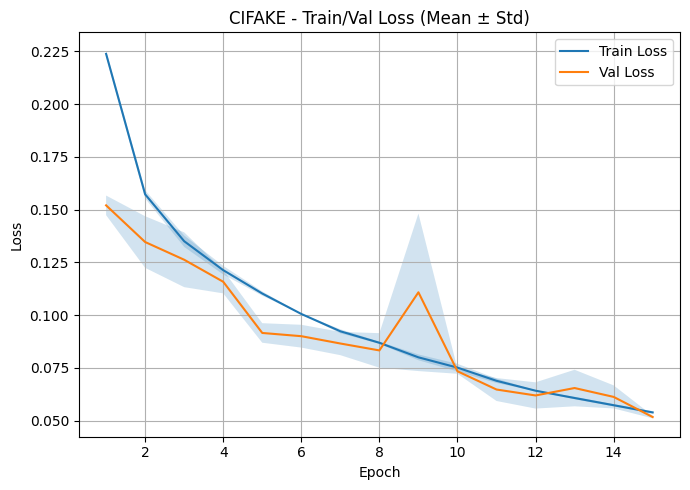

Saved: figures/CIFAKE_loss_curves.png


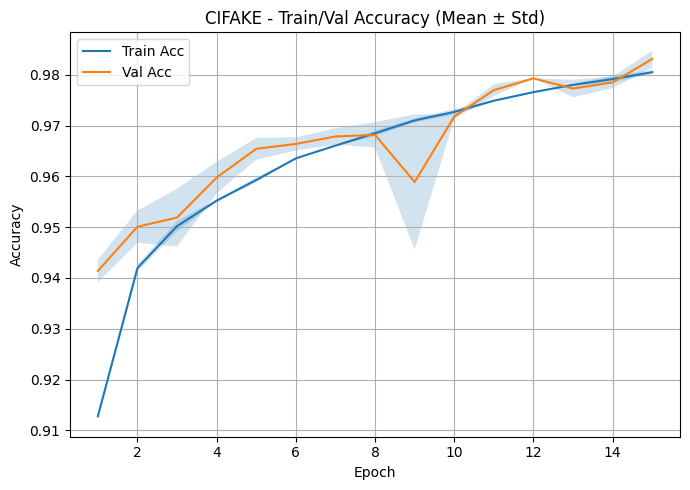

Saved: figures/CIFAKE_accuracy_curves.png


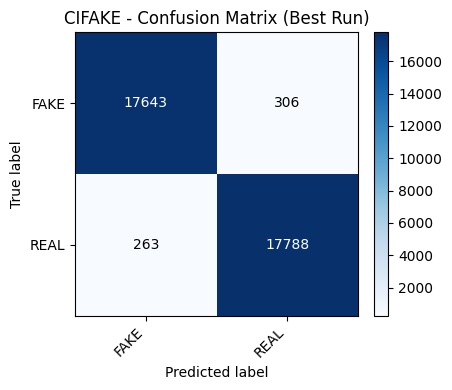

Saved: figures/CIFAKE_confusion_matrix.png

=== Visualization for MidJourney ===


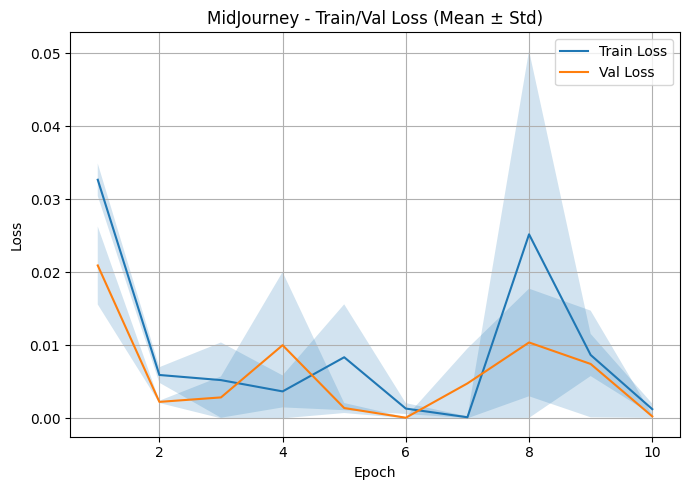

Saved: figures/MidJourney_loss_curves.png


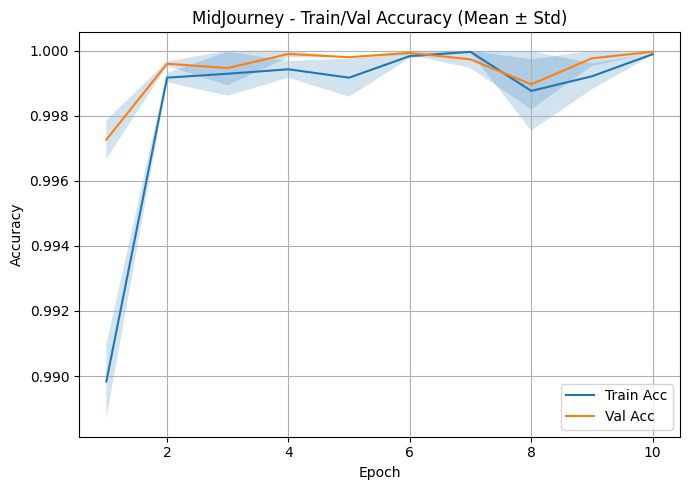

Saved: figures/MidJourney_accuracy_curves.png


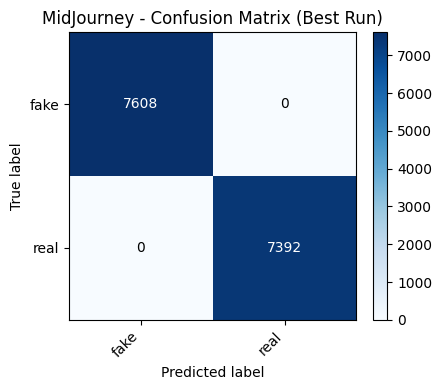

Saved: figures/MidJourney_confusion_matrix.png

=== Visualization for StyleGAN ===


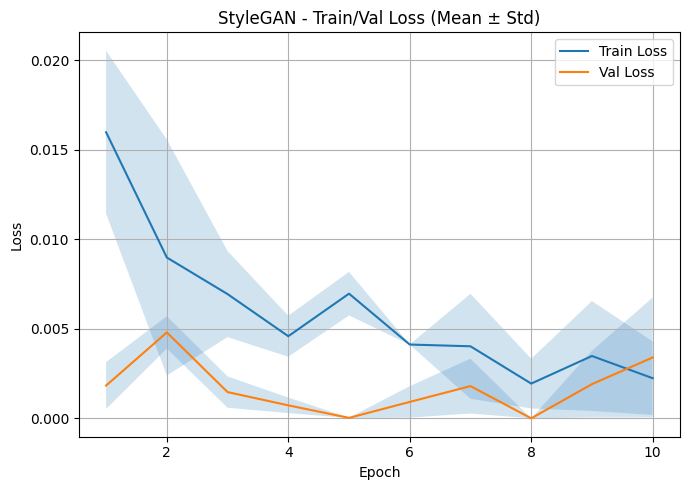

Saved: figures/StyleGAN_loss_curves.png


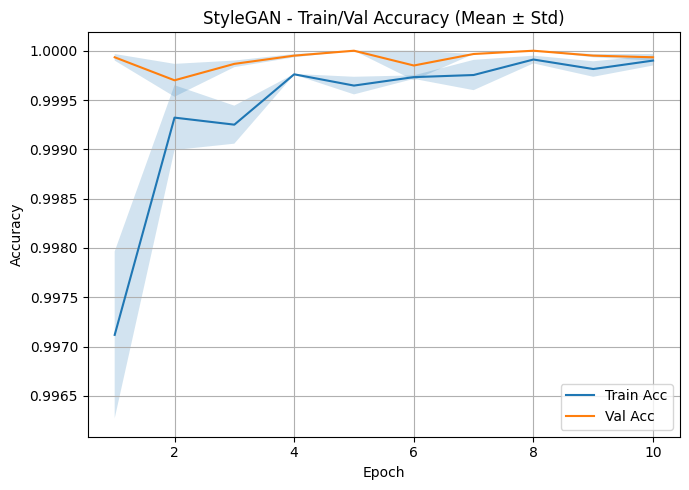

Saved: figures/StyleGAN_accuracy_curves.png


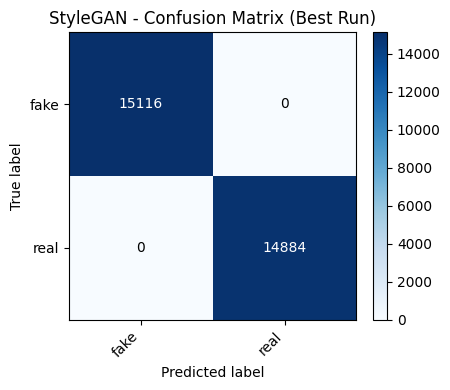

Saved: figures/StyleGAN_confusion_matrix.png


In [8]:
os.makedirs("figures", exist_ok=True)

def plot_with_shaded_std(epochs, mean_vals, std_vals, label, color=None):
    plt.plot(epochs, mean_vals, label=label, color=color)
    plt.fill_between(
        epochs,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.2,
        color=color,
    )

for ds_name, info in all_results.items():
    print(f"\n=== Visualization for {ds_name} ===")

    runs = info["per_run"]
    num_epochs = info["num_epochs"]
    class_names = info["class_names"]
    epochs = np.arange(1, num_epochs + 1)

    # stack histories into arrays: shape (runs, epochs)
    train_loss_all = np.zeros((len(runs), num_epochs))
    val_loss_all = np.zeros((len(runs), num_epochs))
    train_acc_all = np.zeros((len(runs), num_epochs))
    val_acc_all = np.zeros((len(runs), num_epochs))

    accs = []

    for i, r in enumerate(runs):
        h = r["history"]
        train_loss_all[i] = np.array(h["train_loss"])
        val_loss_all[i] = np.array(h["val_loss"])
        train_acc_all[i] = np.array(h["train_acc"])
        val_acc_all[i] = np.array(h["val_acc"])
        accs.append(r["test_acc"])

    accs = np.array(accs)
    best_idx = int(np.argmax(accs))
    best_cm = runs[best_idx]["cm"]

    # --- Loss curves ---
    plt.figure(figsize=(7, 5))
    plot_with_shaded_std(
        epochs,
        train_loss_all.mean(axis=0),
        train_loss_all.std(axis=0),
        label="Train Loss",
    )
    plot_with_shaded_std(
        epochs,
        val_loss_all.mean(axis=0),
        val_loss_all.std(axis=0),
        label="Val Loss",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{ds_name} - Train/Val Loss (Mean ± Std)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    loss_path = f"figures/{ds_name}_loss_curves.png"
    plt.savefig(loss_path, dpi=300)
    plt.show()
    print("Saved:", loss_path)

    # --- Accuracy curves ---
    plt.figure(figsize=(7, 5))
    plot_with_shaded_std(
        epochs,
        train_acc_all.mean(axis=0),
        train_acc_all.std(axis=0),
        label="Train Acc",
    )
    plot_with_shaded_std(
        epochs,
        val_acc_all.mean(axis=0),
        val_acc_all.std(axis=0),
        label="Val Acc",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{ds_name} - Train/Val Accuracy (Mean ± Std)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    acc_path = f"figures/{ds_name}_accuracy_curves.png"
    plt.savefig(acc_path, dpi=300)
    plt.show()
    print("Saved:", acc_path)

    # --- Confusion matrix of best run ---
    plt.figure(figsize=(5, 4))
    im = plt.imshow(best_cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{ds_name} - Confusion Matrix (Best Run)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = best_cm.max() / 2.0
    for i in range(best_cm.shape[0]):
        for j in range(best_cm.shape[1]):
            plt.text(
                j, i, str(best_cm[i, j]),
                ha="center", va="center",
                color="white" if best_cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    cm_path = f"figures/{ds_name}_confusion_matrix.png"
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print("Saved:", cm_path)

## Grad-CAM++ Visualization 

In [11]:
import torch
import matplotlib.pyplot as plt

from torchcam.methods import GradCAMpp  
from torchcam.utils import overlay_mask  
from torchvision.transforms.functional import to_pil_image

def get_single_sample(loader, target_label: int):
    """
    Grab a single sample from the loader with the given class label (0 or 1).
    Returns: (image_tensor, label, index_when_found)
    """
    for batch_idx, (images, labels) in enumerate(loader):
        for i in range(len(labels)):
            if int(labels[i].item()) == target_label:
                return images[i], labels[i], (batch_idx, i)
    raise ValueError(f"No sample with label {target_label} found in loader.")


# Example: Grad-CAM++ on CIFAKE (fresh small training just for demo)
example_ds = DATASETS[0]  # CIFAKE
root = example_ds["root"]
img_size = example_ds["img_size"]

train_loader_v, val_loader_v, test_loader_v, class_names_v = get_dataloaders_70_15_15(
    root=root,
    img_size=img_size,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    run_seed=1234,
    device=cfg.device,
)

model_cam = LightweightCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_cam.parameters(), lr=cfg.lr)

print("\n[Grad-CAM Example] Training a few epochs on CIFAKE for visualization...")
for epoch in range(3):  # small number just to get non-random features
    print(f"Epoch {epoch + 1}/3")
    train_one_epoch(model_cam, train_loader_v, criterion, optimizer, device)

model_cam.eval()

# pick one REAL (label=1) and one FAKE (label=0) from test loader
real_img, real_label, _ = get_single_sample(test_loader_v, target_label=1)
fake_img, fake_label, _ = get_single_sample(test_loader_v, target_label=0)

# last conv block as target layer
targets_layer = model_cam.features[-1]

# ✅ torchcam Grad-CAM++
cam_extractor = GradCAMpp(model_cam, target_layer=targets_layer)


def visualize_cam(input_img, title: str):
    # de-normalize (assuming roughly [-1, 1] from mean=0.5, std=0.5)
    img_denorm = input_img * 0.5 + 0.5
    pil_img = to_pil_image(img_denorm.cpu())

    # forward pass
    input_batch = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_cam(input_batch)

    # for binary classifier with BCELoss (single output), class index = 0
    class_idx = 0

    # get CAM
    activation_map = cam_extractor(class_idx, output)[0].cpu()

    # overlay heatmap on image
    result = overlay_mask(pil_img, activation_map, alpha=0.5)

    plt.figure(figsize=(4, 4))
    plt.imshow(result)
    plt.axis("off")
    plt.title(title)
    plt.show()


visualize_cam(real_img, title=f"{class_names_v[1]} (Real) - Grad-CAM++")
visualize_cam(fake_img, title=f"{class_names_v[0]} (Fake) - Grad-CAM++")



[Grad-CAM Example] Training a few epochs on CIFAKE for visualization...
Epoch 1/3


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 2/3


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 3/3


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

RuntimeError: cannot register a hook on a tensor that doesn't require gradient